In [1]:
from jax.scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import numpy as np
import optax
from PIL import Image
import jax.numpy as jnp
import jax
from drawingwithgaussians.rendering2d import rasterize, pixel_loss

seed = 0
key = jax.random.key(seed)

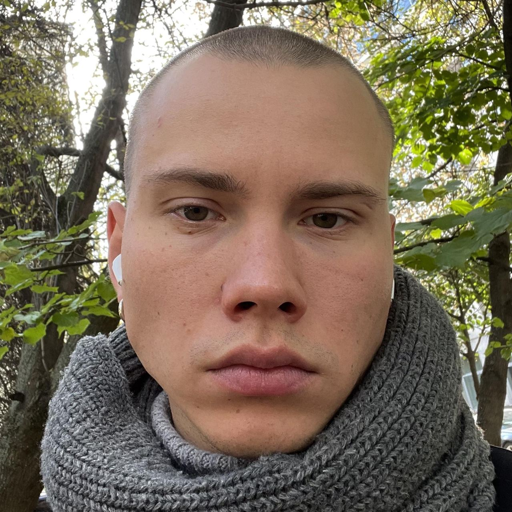

In [2]:
path = '/Users/gleb/Downloads/artem.jpg'
img = Image.open(path)
img.resize((512, 512))

In [16]:
height = 128
width = 128
angle = 0.
num_gaussians = 5
lr = 1e-3
max_steps = 10000
learning_rate_schedule = optax.constant_schedule(lr) #(lr, max_steps)

target_image = jnp.array(img.resize((height, width)), dtype=jnp.float32)[:, :, :3] / 255
background_color = jax.random.uniform(key, (1, 1, 3), jnp.float32, 0, 1)
means = jax.random.uniform(key, (num_gaussians, 2), minval=0, maxval=height, dtype=jnp.float32)
sigmas = jax.random.uniform(key, (num_gaussians, 2), minval=5, maxval=24, dtype=jnp.float32)
covariances = jnp.stack([jnp.diag(sigma**2) for sigma in sigmas])
colors = jax.random.uniform(key, (num_gaussians, 4), jnp.float32, 0, 1)
colors = colors.at[:, 3].set(colors[:, 3])
r = R.from_euler('x', [angle,])
rotmats = jnp.repeat(r.as_matrix()[1:, 1:][None], num_gaussians, axis=0)

optimize_means = optax.adam(learning_rate_schedule)
optimize_cov = optax.adam(learning_rate_schedule)
optimize_colors = optax.adam(learning_rate_schedule)
optimize_rotmats = optax.adam(learning_rate_schedule)
optimize_background = optax.adam(learning_rate_schedule)

opt_state_means = optimize_means.init(means)
opt_state_cov = optimize_cov.init(sigmas)
opt_state_colors = optimize_colors.init(colors)
opt_state_rotmats = optimize_rotmats.init(rotmats)
opt_state_background = optimize_background.init(background_color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


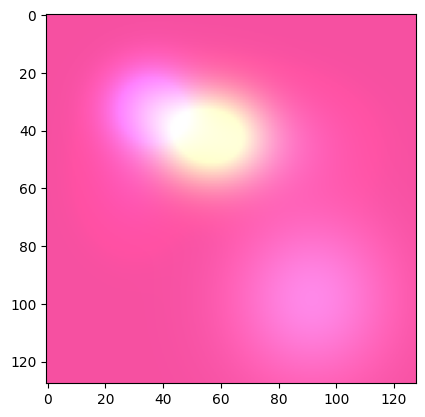

In [17]:
background = jnp.repeat(jnp.repeat(background_color, height, axis=0), width, axis=1)
renderred_gaussians, opacity = rasterize(means, covariances, colors, rotmats, background, height, width)
plt.imshow(renderred_gaussians)

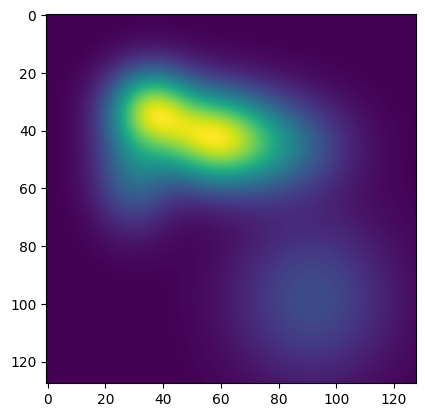

In [18]:
plt.imshow(opacity)

In [19]:
prev_stats = []
for step in range(max_steps):
    loss, gradients = jax.value_and_grad(pixel_loss, argnums=[0, 1, 2, 3, 4])(means, sigmas, colors, rotmats, background_color, target_image)
    
    updates_means, opt_state_means = optimize_means.update(gradients[0], opt_state_means)
    means = optax.apply_updates(means, updates_means)

    updates_cov, opt_state_cov = optimize_cov.update(gradients[1], opt_state_cov)
    sigmas = optax.apply_updates(sigmas, updates_cov)

    updates_colors, opt_state_colors = optimize_colors.update(gradients[2], opt_state_colors)
    colors = optax.apply_updates(colors, updates_colors)

    updates_rotmats, opt_state_rotmats = optimize_colors.update(gradients[3], opt_state_rotmats)
    rotmats = optax.apply_updates(rotmats, updates_rotmats)

    updates_background, opt_state_background = optimize_background.update(gradients[4], opt_state_background)
    background_color = optax.apply_updates(background_color, updates_background)

    if jnp.isnan(loss):
        print(prev_stats)
        print(loss, [(jnp.linalg.norm(gradient), gradient.max()) for gradient in gradients])
        break
    if step % 50 == 0:
        print(loss, step)
    prev_stats = [(jnp.linalg.norm(gradient), gradient.max()) for gradient in gradients]

0.1061277 [(Array(8.919313e-05, dtype=float32), Array(6.0002927e-05, dtype=float32)), (Array(0.00038065, dtype=float32), Array(0.00017731, dtype=float32)), (Array(0.01630917, dtype=float32), Array(0.0148749, dtype=float32)), (Array(0.00286551, dtype=float32), Array(0.00158181, dtype=float32)), (Array(0.06323034, dtype=float32), Array(0.04638261, dtype=float32))]
0.09870134 [(Array(7.563235e-05, dtype=float32), Array(5.323838e-05, dtype=float32)), (Array(0.0002775, dtype=float32), Array(0.00013132, dtype=float32)), (Array(0.01410638, dtype=float32), Array(0.01302913, dtype=float32)), (Array(0.00221379, dtype=float32), Array(0.00121816, dtype=float32)), (Array(0.06106902, dtype=float32), Array(0.04517373, dtype=float32))]
0.09212048 [(Array(6.435931e-05, dtype=float32), Array(4.6923386e-05, dtype=float32)), (Array(0.00019742, dtype=float32), Array(9.411311e-05, dtype=float32)), (Array(0.01217429, dtype=float32), Array(0.01138576, dtype=float32)), (Array(0.00169274, dtype=float32), Array(

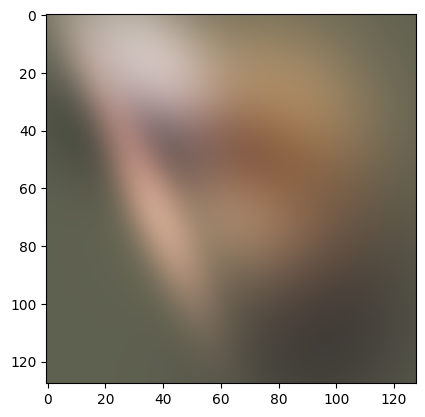

In [ ]:
covariances = jnp.stack([jnp.diag(sigma**2) for sigma in sigmas])
background = jnp.repeat(jnp.repeat(background_color, height, axis=0), width, axis=1)
renderred_gaussians, opacity = rasterize(means, covariances, colors, rotmats, background, height, width)
plt.imshow(jax.nn.sigmoid(renderred_gaussians))

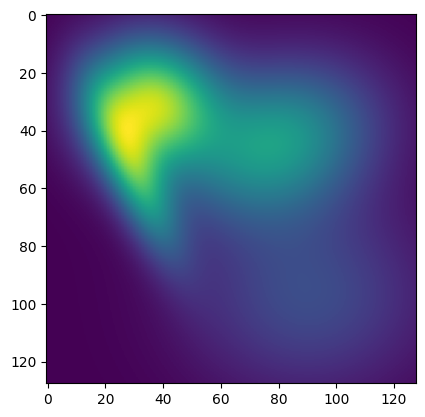

In [8]:
plt.imshow(opacity)